## Tesla Revenue from second quarter 2010 to first quarter 2025 with uptodate stock data

#### 1. install alle the neccessary packages 

In [1]:
!pip install yfinance 
!pip install bs4
!pip install nbformat
!pip install html5lib



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


#### 2. In case there are multiple Python installed , make sure packages are specifically installed on targeted Python using sys

In [2]:
import sys
print(sys.executable)

/opt/anaconda3/envs/myenv/bin/python


In [3]:
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pdfplumber

#### 3. Import all neccessary packages (including for scraping and ploting)

In [4]:
import yfinance as yf
import pandas as pd
import requests
import time
from decimal import Decimal, ROUND_HALF_UP
import re
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
import matplotlib.pyplot as plt


#### 4. Calling tesla sotck data using Ticker and adjust in data frame 

In [5]:
tesla=yf.Ticker('TSLA')

In [6]:
tesla_data = tesla.history(period='max')


In [7]:
tesla_data.reset_index(inplace=True)
tesla_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
3729,2025-04-25 00:00:00-04:00,261.690002,286.850006,259.630005,284.950012,167560700,0.0,0.0
3730,2025-04-28 00:00:00-04:00,288.980011,294.859985,272.420013,285.880005,151731800,0.0,0.0
3731,2025-04-29 00:00:00-04:00,285.500000,293.320007,279.470001,292.029999,108906600,0.0,0.0
3732,2025-04-30 00:00:00-04:00,279.899994,284.450012,270.779999,282.160004,128961100,0.0,0.0


#### 5. Scraping Tesla's SEC filling website and exporting the resukt in csv

In [8]:

CIK = '0001318605'
submissions_url = f'https://data.sec.gov/submissions/CIK{CIK}.json'
headers = {'User-Agent': 'Mozilla/5.0 (compatible; your-email@example.com)'}  # Set real email

# Get recent filings (2017-now)
resp = requests.get(submissions_url, headers=headers)
data = resp.json()
filings = data['filings']['recent']

entries = []
for form, acc_no, file_name, date_filed in zip(
    filings['form'], filings['accessionNumber'], filings['primaryDocument'], filings['filingDate']
):
    if form in ('10-Q', '10-K'):
        acc_no_clean = acc_no.replace('-', '')
        url = f'https://www.sec.gov/Archives/edgar/data/{CIK.strip("0")}/{acc_no_clean}/{file_name}'
        entries.append((form, date_filed, url))

# Add old entries (2010–2016) manually
old_entries = [
    # 2010
    ('10-Q', '2010-08-13', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312510188792/d10q.htm'),
    ('10-Q', '2010-11-12', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312510259068/d10q.htm'),
    ('10-K', '2011-03-03', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312511054847/d10k.htm'),

    # 2011
    ('10-Q', '2011-05-13', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312511139677/d10q.htm'),
    ('10-Q', '2011-08-12', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312511221497/d10q.htm'),
    ('10-Q', '2011-11-14', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312511308489/d226201d10q.htm'),
    ('10-K', '2012-02-27', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312512081990/d279413d10k.htm'),

    # 2012
    ('10-Q', '2012-05-10', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312512225825/d325967d10q.htm'),
    ('10-Q', '2012-08-02', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312512332138/d364775d10q.htm'),
    ('10-Q', '2012-11-07', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312512457610/d410318d10q.htm'),
    ('10-K', '2013-03-07', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312513096241/d452995d10k.htm'),

    # 2013
    ('10-Q', '2013-05-10', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312513212354/d511008d10q.htm'),
    ('10-Q', '2013-08-09', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312513327916/d549636d10q.htm'),
    ('10-Q', '2013-11-08', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312513435480/d588506d10q.htm'),
    ('10-K', '2014-02-26', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312514069681/d668062d10k.htm'),

    # 2014
    ('10-Q', '2014-05-09', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312514192606/d715897d10q.htm'),
    ('10-Q', '2014-08-08', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312514303175/d766922d10q.htm'),
    ('10-Q', '2014-11-07', 'https://www.sec.gov/Archives/edgar/data//1318605/000119312514403635/d812482d10q.htm'),
    ('10-K', '2015-02-26', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459015001031/tsla-10k_20141231.htm'),

    # 2015
    ('10-Q', '2015-05-08', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459015003789/tsla-10q_20150331.htm'),
    ('10-Q', '2015-08-07', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459015006666/tsla-10q_20150630.htm'),
    ('10-Q', '2015-11-05', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459015009741/tsla-10q_20150930.htm'),
    ('10-K', '2016-02-24', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459016013195/tsla-10k_20151231.htm'),

    # 2016
    ('10-Q', '2016-05-10', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459016018886/tsla-10q_20160331.htm'),
    ('10-Q', '2016-08-05', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459016023024/tsla-10q_20160630.htm'),
    ('10-Q', '2016-11-01', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459016026820/tsla-10q_20160930.htm'),
    ('10-K', '2017-03-01', 'https://www.sec.gov/Archives/edgar/data//1318605/000156459017003118/tsla-10k_20161231.htm')
]

entries += old_entries
entries.sort(key=lambda x: x[1])  # sort by date_filed

# Scrape revenue from filings
revenue_data = []  # Will store all data including report dates

# These are taken directly from Tesla's SEC filings
known_values = {
    # Format: (year, period): value in millions
    ('2019', 'FY'): 24578,  
    ('2020', 'FY'): 31536,  
    ('2021', 'FY'): 53823,  
    ('2022', 'FY'): 81462,  
    ('2023', 'FY'): 96773,  
    ('2024', 'FY'): 97690,
}


def parse_revenue_from_url(url, year, period):
    # First check if we have known value for this year/period
    if (year, period) in known_values:
        return known_values[(year, period)]
    
    resp = requests.get(url, headers=headers)
    if resp.content.strip().startswith(b'<?xml'):
        soup = BeautifulSoup(resp.content, 'xml')
    else:
        soup = BeautifulSoup(resp.content, 'html.parser')
    
    # Try to find the unit (in thousands or millions)
    unit_multiplier = 1  # Default multiplier (no change)
    
    # Look for statements indicating the unit in the document
    unit_text = soup.find(string=re.compile(r'(in thousands|in millions)', re.IGNORECASE))
    if unit_text:
        if re.search(r'in thousands', unit_text, re.IGNORECASE):
            unit_multiplier = 0.001  # Convert thousands to millions
    
    # If we couldn't find it in general text, look in table descriptions
    if unit_multiplier == 1:
        for table in soup.find_all('table'):
            table_text = table.get_text()
            if re.search(r'in thousands', table_text, re.IGNORECASE):
                unit_multiplier = 0.001
                break
    
    # search for the revenue
    for table in soup.find_all('table'):
        if 'Total revenues' in table.get_text():
            for row in table.find_all('tr'):
                cells = row.find_all(['td', 'th'])
                if len(cells) >= 2:
                    label = cells[0].get_text(strip=True).lower()
                    if 'total revenues' in label:
                        for cell in cells[1:]:
                            text_value = cell.get_text(strip=True)
                            clean_value = text_value.replace('$', '')
                            
                            if re.search(r'\d', clean_value):
                                try:
                                    # Handle commas as thousand separators
                                    clean_value = clean_value.replace(',', '')
                                    # Convert to float only if it looks valid
                                    if re.match(r'^\d+(\.\d+)?$', clean_value):
                                        numeric_value = float(clean_value)
                                    
                                    # Check for plausibility because a recent year values could be large
                                    filing_year = int(year)
                                    
                                    # Apply the unit multiplier
                                    final_value = numeric_value * unit_multiplier
                                    
                                    # Additional validation based on year
                                    if filing_year >= 2019 and period == 'FY' and final_value < 1000:
                                        # This is likely a case of misinterpreted commas
                                        # If the raw value has a decimal point after the first few digits
                                        # it might be a comma-as-decimal issue
                                        if '.' in clean_value and len(clean_value.split('.')[0]) <= 3:
                                            corrected = final_value * 1000
                                            final_value = corrected
                                    
                                    return final_value
                                    
                                except ValueError:
                                    continue
    return None


# Dictionary to store quarterly data for calculating Q4 values later
revenue_by_year = defaultdict(dict)

for form, date_filed, url in entries:
    if form == '10-K':
        year = str(int(date_filed[:4]) - 1)  # Adjust for FY
        period = 'FY'
    elif form == '10-Q':
        year = date_filed[:4]
        month = int(date_filed[5:7])
        if month <= 5:
            period = 'Q1'
        elif month <= 8:
            period = 'Q2'
        else:
            period = 'Q3'
    else:
        continue

    revenue = parse_revenue_from_url(url, year, period)
    if revenue:
        # Store in revenue_by_year for Q4 calculations later
        revenue_by_year[year][period] = revenue
        
        # Add to our main results with report date
        revenue_data.append({
            'year': year,
            'quarter': period,
            'revenue_in_millions($)': revenue,
            'report_date': date_filed  # Store the exact filing date
        })
    else:
        revenue_by_year[year][period] = None
    time.sleep(1)  # Be nice to the SEC server

# Calculate Q4 values where missing
for year, revs in revenue_by_year.items():
    if 'FY' in revs and all(q in revs for q in ('Q1', 'Q2', 'Q3')) and 'Q4' not in revs:
        try:
            q1 = revs['Q1']
            q2 = revs['Q2']
            q3 = revs['Q3']
            fy = revs['FY']
            
            # Ensure all are valid numbers
            if all(isinstance(val, (int, float)) for val in [q1, q2, q3, fy]) and all(val is not None for val in [q1, q2, q3, fy]):
                q4 = fy - (q1 + q2 + q3)
                # Only set if Q4 is not negative or suspicious
                if q4 >= 0:
                    revenue_by_year[year]['Q4'] = round(q4, 2)
                    
                    # For Q4, use report date from Q3 but add 3 months
                    # Find Q3 report date for this year
                    q3_report = None
                    for entry in revenue_data:
                        if entry['year'] == year and entry['quarter'] == 'Q3':
                            q3_report = entry['report_date']
                            break
                    
                    # If we found Q3 report date, calculate estimated Q4 report date
                    if q3_report:
                        # Simple estimation: add 3 months to Q3 report date
                        q3_date = pd.to_datetime(q3_report)
                        q4_date = q3_date + pd.DateOffset(months=3)
                        q4_report_date = q4_date.strftime('%Y-%m-%d')
                    else:
                        # If no Q3 report found, use year-end with estimated month
                        q4_report_date = f"{year}-12-31"
                    
                    # Add calculated Q4 to our main results
                    revenue_data.append({
                        'year': year,
                        'quarter': 'Q4',
                        'revenue_in_millions($)': round(q4, 2),
                        'report_date': q4_report_date,
                        'calculated': True  # Mark as calculated
                    })
                else:
                    revenue_by_year[year]['Q4'] = None
            else:
                revenue_by_year[year]['Q4'] = None
        except Exception as e:
            revenue_by_year[year]['Q4'] = None

# Perform sanity checks
for year in sorted(revenue_by_year.keys()):
    quarters = revenue_by_year[year]
    if 'FY' in quarters and all(q in quarters for q in ['Q1', 'Q2', 'Q3']):
        # Filter out None values before summing
        q_values = [quarters.get(q, 0) for q in ['Q1', 'Q2', 'Q3']]
        q_values = [v for v in q_values if v is not None]  # Filter out None values
        
        if len(q_values) == 3:  # Only if we have all 3 quarters with valid values
            q_sum = sum(q_values)
            q4 = quarters.get('Q4', 0)
            if q4 is None:
                q4 = 0
                
            fy = quarters['FY']
            if fy is not None:
                total_sum = q_sum + q4
                ratio = fy / total_sum if total_sum > 0 else 0
                
                if abs(ratio - 1.0) > 0.1:  # More than 10% difference
                    print(f"WARNING: Possible discrepancy in {year} data")

# Convert to DataFrame
df = pd.DataFrame(revenue_data)

# Round revenue values
df['revenue_in_millions($)'] = df['revenue_in_millions($)'].apply(lambda x: round(x, 2) if pd.notnull(x) else None)

# Sort by year and quarter (with custom sorting for quarters)
quarter_order = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4, 'FY': 5}
df['quarter_order'] = df['quarter'].map(quarter_order)
df = df.sort_values(by=['year', 'quarter_order'])
df = df.drop('quarter_order', axis=1)

# Flag calculated values (mostly Q4)
if 'calculated' not in df.columns:
    df['calculated'] = False

# Export to CSV
df.to_csv('tesla_revenue.csv', index=False)

print("\n=== Final Data ===")
print(df[['year', 'quarter', 'revenue_in_millions($)', 'report_date']])


=== Final Data ===
    year quarter  revenue_in_millions($) report_date
0   2010      Q2                   28.41  2010-08-13
1   2010      Q3                   31.24  2010-11-12
2   2010      FY                  116.74  2011-03-03
3   2011      Q1                   49.03  2011-05-13
4   2011      Q2                   58.17  2011-08-12
..   ...     ...                     ...         ...
57  2024      Q2                25500.00  2024-07-24
58  2024      Q3                25182.00  2024-10-24
74  2024      Q4                25707.00  2025-01-24
59  2024      FY                97690.00  2025-01-30
60  2025      Q1                19335.00  2025-04-23

[75 rows x 4 columns]


#### 6. Annual Revenue of TESLA from 2010 to 2024


In [9]:
fullYear_df = df[df['quarter']== 'FY'].copy()

fullYear_df=fullYear_df.drop(columns=['quarter', 'calculated'])
fullYear_df.reset_index(drop=True)

,year,revenue_in_millions($),report_date
0,2010,116.74,2011-03-03
1,2011,204.24,2012-02-27
2,2012,413.26,2013-03-07
3,2013,2013.50,2014-02-26
4,2014,3198.36,2015-02-26
5,2015,4046.03,2016-02-24
6,2016,7000.13,2017-03-01
7,2016,7000.13,2017-03-01
8,2017,11758.75,2018-02-23
9,2018,21461.27,2019-02-19


#### 7. Cleaned version of tesla revenue data

In [10]:
tesla_qRevenue=df[df['quarter'] != "FY"]
tesla_qRevenue = tesla_qRevenue.drop(columns=['calculated'])
# Define standard rounding function
def standard_round(x):
    try:
        return str(int(Decimal(str(x)).quantize(0, rounding=ROUND_HALF_UP)))
    except:
        return ''
tesla_qRevenue['revenue_in_millions($)'] = tesla_qRevenue['revenue_in_millions($)'].apply(standard_round)
tesla_qRevenue.reset_index(drop=True)
tesla_qRevenue.to_csv("tesla_revenue_cleaned.csv",index=False)

#### 8. Line graph of the revenue of Tesla throughout 15 years

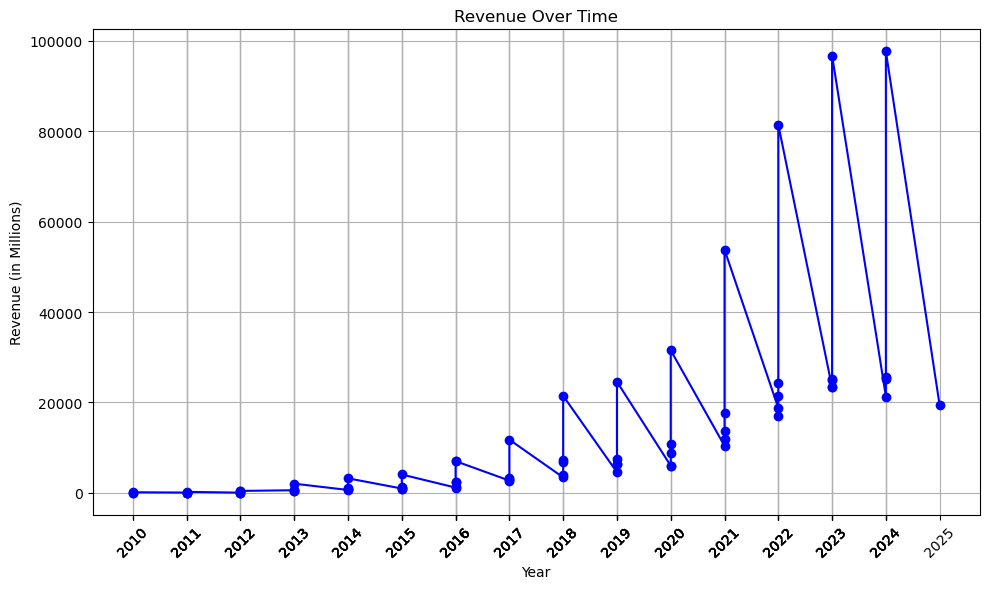

In [11]:
tesla_qRevenue['year'] = df['year'].astype(int)
tesla_qRevenue['revenue_in_millions($)'] = pd.to_numeric(df['revenue_in_millions($)'], errors='coerce')

# Sort by year in case it's not sorted
tesla_qRevenue = tesla_qRevenue.sort_values(by='year')

# Plot line graph
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['revenue_in_millions($)'], marker='o', linestyle='-', color='blue')
plt.title('Revenue Over Time')
plt.xlabel('Year')
plt.ylabel('Revenue (in Millions)')
plt.grid(True)
plt.xticks(df['year'], rotation=45)
plt.tight_layout()
plt.show()

#### 9. Scattered graph to show the relation between Tesla Stock and revenue from 2010 to 2025

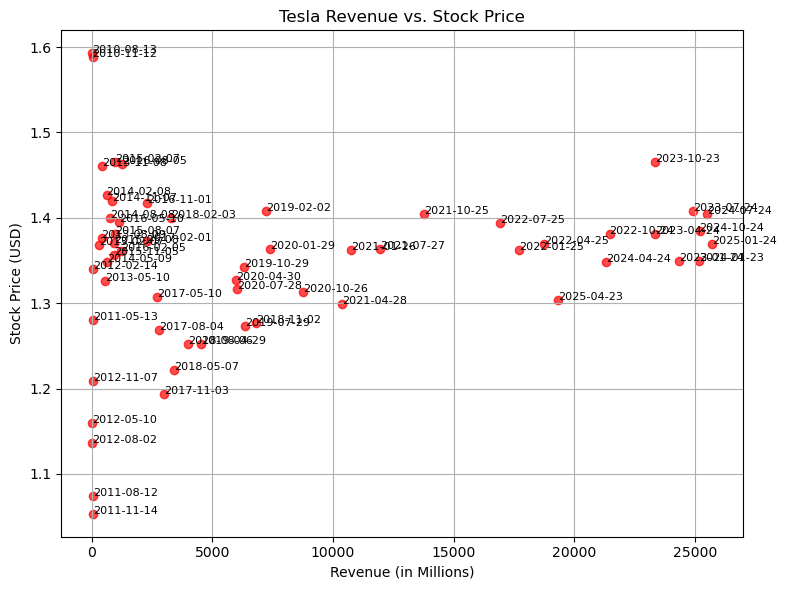

In [12]:
# Convert to numeric
tesla_qRevenue['revenue_in_millions($)'] = pd.to_numeric(tesla_qRevenue['revenue_in_millions($)'], errors='coerce')
tesla_data['Close'] = pd.to_numeric(tesla_data['Close'], errors='coerce')

# Combine into one DataFrame based on common index or date if needed
df = pd.DataFrame({
    'Revenue': tesla_qRevenue['revenue_in_millions($)'],
    'Close': tesla_data['Close'],
    'Date': tesla_qRevenue['report_date']  # Assuming alignment
})

# Drop rows with NaNs
df.dropna(inplace=True)

# Plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(df['Revenue'], df['Close'], color='red', alpha=0.7)

# Annotate points with dates
for i in range(len(df)):
    plt.annotate(str(df['Date'].iloc[i]), (df['Revenue'].iloc[i], df['Close'].iloc[i]), fontsize=8)

plt.title('Tesla Revenue vs. Stock Price')
plt.xlabel('Revenue (in Millions)')
plt.ylabel('Stock Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Author: Solomon Mengesha Kebede © extracted Tesla data
### Please let me know if you want to use the data for your project : solo_men@yahoo.com

In [13]:
!git add .
!git commit -m "first commit from Jupyter Notebook"
!git push -u origin main

[main d3cff31] first commit from Jupyter Notebook
 1 file changed, 158 insertions(+), 272 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 11 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.86 KiB | 954.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SolomonM-Kebede/Tesla-Revenue-and-Stock-data-Analysis.git
   fc7fcee..d3cff31  main -> main
branch 'main' set up to track 'origin/main'.
